# RNN in PyTorch

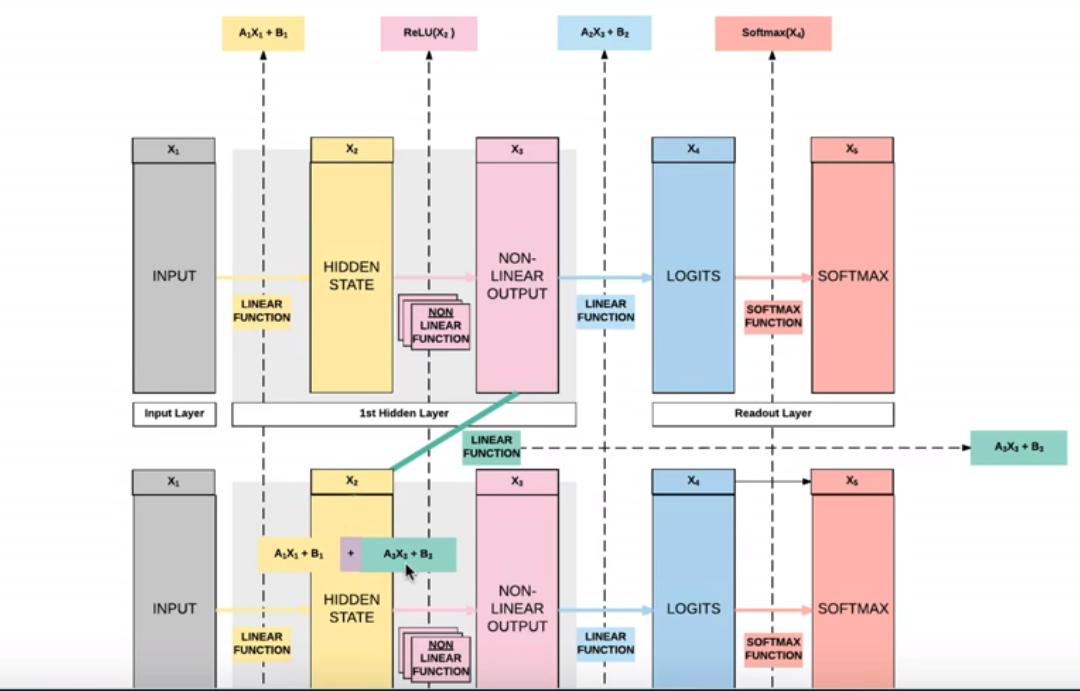

In [3]:
from IPython.display import Image
Image(filename='1.png')

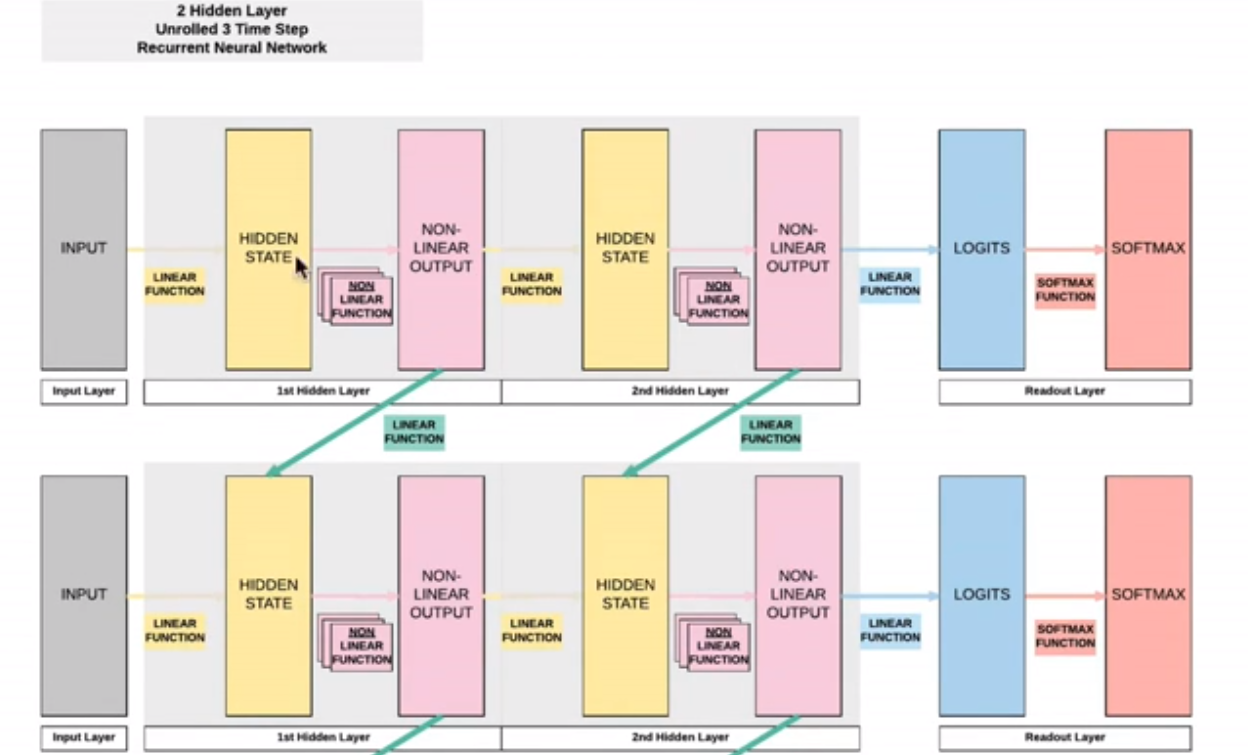

In [4]:
from IPython.display import Image
Image(filename='2.png')

# Model A: 1 Hidden Layer(Relu)

unroll 28 time step

    each step input size:28*1
            
    total per unroll 28* 28
    
very similar to ffn(input size is 28*28)

1 step goes from input to softmax

In [5]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

train_dataset = dsets.MNIST(root='./data',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

In [6]:
print(train_dataset.train_data.size())

torch.Size([60000, 28, 28])


In [7]:
#hyper-parameters like learning rate and size of the model

print(train_dataset.train_labels.size())

torch.Size([60000])


In [8]:
print(test_dataset.test_data.size())

torch.Size([10000, 28, 28])


In [9]:
print(test_dataset.test_labels.size())

torch.Size([10000])


In [10]:
batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [11]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # Building your RNN
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, input_dim)
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        # (layer_dim, batch_size, hidden_dim)
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        
        out, hn = self.rnn(x, h0)
        
        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states!
        out = self.fc(out[:, -1, :])
        # out.size() --> 100, 10
        return out

In [12]:
input_dim = 28
hidden_dim = 100
layer_dim = 1
output_dim = 10

In [13]:
model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

In [14]:
criterion = nn.CrossEntropyLoss()

In [15]:
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [16]:
len(list(model.parameters()))

6

In [17]:

# Input --> Hidden (A1)
list(model.parameters())[0].size()

torch.Size([100, 28])

In [18]:
# Input --> Hidden BIAS (B1)
list(model.parameters())[2].size()

torch.Size([100])

In [19]:
# Hidden --> Hidden (A3)
list(model.parameters())[1].size()

torch.Size([100, 100])

In [20]:
# Hidden --> Hidden BIAS(B3)
list(model.parameters())[3].size()

torch.Size([100])

In [21]:
# Hidden --> Output (A2)
list(model.parameters())[4].size()

torch.Size([10, 100])

In [22]:
# Hidden --> Output BIAS (B2)
list(model.parameters())[5].size()

torch.Size([10])

In [23]:
# Number of steps to unroll
seq_dim = 28

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as Variable
        images = Variable(images.view(-1, seq_dim, input_dim))
        labels = Variable(labels)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get ouput/logits
        # outputs.size() --> 100, 10
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. paramaters
        loss.backward()
          # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                # Load images to a Torch Variable
                images = Variable(images.view(-1, seq_dim, input_dim))
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                correct += (predicted == labels).sum()
                
            accuracy = 100 * correct / total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data[0], accuracy))

C:\Users\G2945\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iteration: 500. Loss: 1.246362328529358. Accuracy: 51
Iteration: 1000. Loss: 1.2141461372375488. Accuracy: 57
Iteration: 1500. Loss: 1.0012401342391968. Accuracy: 68
Iteration: 2000. Loss: 0.7286655902862549. Accuracy: 78
Iteration: 2500. Loss: 0.3645356297492981. Accuracy: 88
Iteration: 3000. Loss: 0.319499671459198. Accuracy: 90
